The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.0
!pip install -U mxnet-cu101==1.7.0


     |████████████████████████████████| 83 kB 1.2 MB/s 
     |███████████████████████████████▌| 834.1 MB 1.1 MB/s eta 0:00:12tcmalloc: large alloc 1147494400 bytes == 0x560035c6e000 @  0x7f0598c8e615 0x55fffbb9a4cc 0x55fffbc7a47a 0x55fffbb9d2ed 0x55fffbc8ee1d 0x55fffbc10e99 0x55fffbc0b9ee 0x55fffbb9ebda 0x55fffbc10d00 0x55fffbc0b9ee 0x55fffbb9ebda 0x55fffbc0d737 0x55fffbc8fc66 0x55fffbc0cdaf 0x55fffbc8fc66 0x55fffbc0cdaf 0x55fffbc8fc66 0x55fffbc0cdaf 0x55fffbb9f039 0x55fffbbe2409 0x55fffbb9dc52 0x55fffbc10c25 0x55fffbc0b9ee 0x55fffbb9ebda 0x55fffbc0d737 0x55fffbc0b9ee 0x55fffbb9ebda 0x55fffbc0c915 0x55fffbb9eafa 0x55fffbc0cc0d 0x55fffbc0b9ee
     |████████████████████████████████| 846.0 MB 21 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import math
from mxnet import autograd, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Position Encoding


In [ ]:
class PositionalEncoding(nn.Block):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = np.zeros((1, max_len, num_hiddens))
        X = np.arange(max_len).reshape(-1, 1) / np.power(
            10000,
            np.arange(0, num_hiddens, 2) / num_hiddens)
        self.P[:, :, 0::2] = np.sin(X)
        self.P[:, :, 1::2] = np.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].as_in_ctx(X.ctx)
        return self.dropout(X)

In the positional embedding matrix $\mathbf{P}$,
[**rows correspond to positions within a sequence
and columns represent different positional encoding dimensions**].
In the example below,
we can see that
the $6^{\mathrm{th}}$ and the $7^{\mathrm{th}}$
columns of the positional embedding matrix 
have a higher frequency than 
the $8^{\mathrm{th}}$ and the $9^{\mathrm{th}}$
columns.
The offset between 
the $6^{\mathrm{th}}$ and the $7^{\mathrm{th}}$ (same for the $8^{\mathrm{th}}$ and the $9^{\mathrm{th}}$) columns
is due to the alternation of sine and cosine functions.


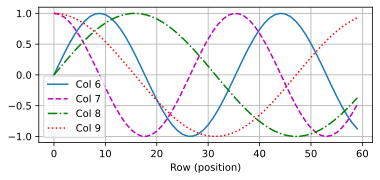

In [ ]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.initialize()
X = pos_encoding(np.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(np.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in np.arange(6, 10)])

### Absolute Positional Information

To see how the monotonically decreased frequency
along the encoding dimension relates to absolute positional information,
let us print out [**the binary representations**] of $0, 1, \ldots, 7$.
As we can see,
the lowest bit, the second-lowest bit, and the third-lowest bit alternate on every number, every two numbers, and every four numbers, respectively.


In [ ]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


In binary representations,
a higher bit has a lower frequency than a lower bit.
Similarly,
as demonstrated in the heat map below,
[**the positional encoding decreases
frequencies along the encoding dimension**]
by using trigonometric functions.
Since the outputs are float numbers,
such continuous representations
are more space-efficient
than binary representations.


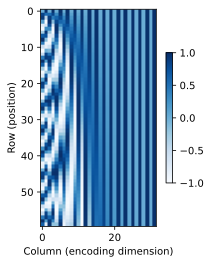

In [ ]:
P = np.expand_dims(np.expand_dims(P[0, :, :], 0), 0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')